In [148]:
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

import numpy as np
import pandas as pd
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

# Nạp dữ liệu

In [205]:
df = pd.read_csv('a10.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
df.head()

,value
date,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869


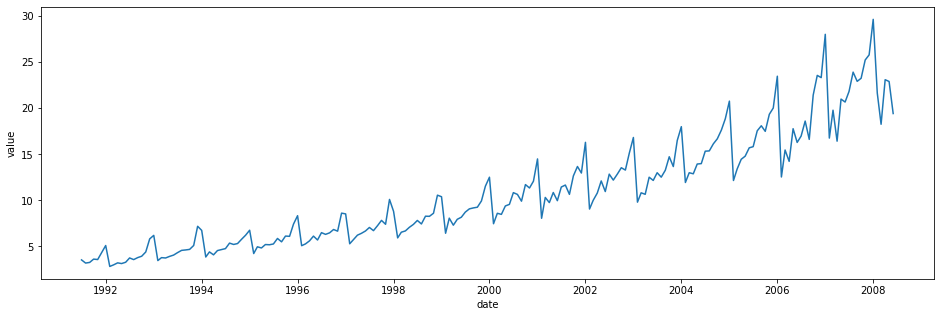

In [206]:
plt.figure(figsize=(16, 5))
sns.lineplot(data=df, x='date', y='value')
plt.show()

# Phân rã thành phần xu hướng và seasonality của chuỗi thời gian

## Additive model

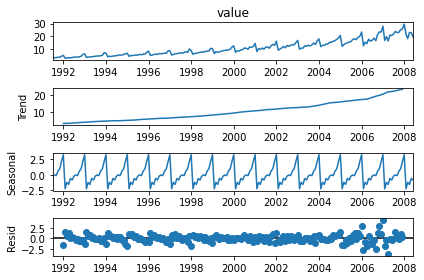

In [207]:
additive_model = seasonal_decompose(df['value'], model='additive')
additive_model.plot()
plt.show()

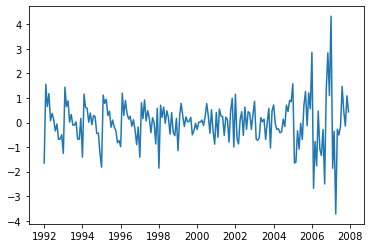

In [208]:
plt.plot(additive_model.resid)
plt.show()

## Multiplicative model

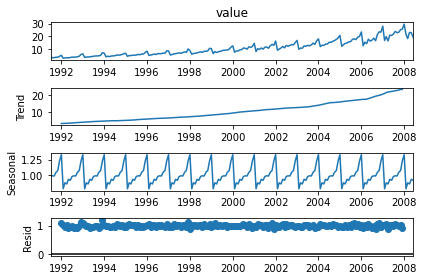

In [209]:
multiplicative_model = seasonal_decompose(df['value'], model='multiplicative')
multiplicative_model.plot()
plt.show()

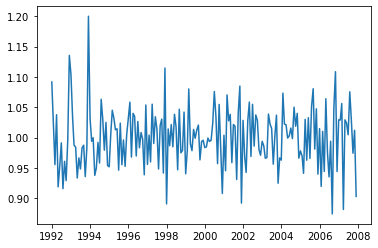

In [210]:
plt.plot(multiplicative_model.resid)
plt.show()

## Biến đổi log

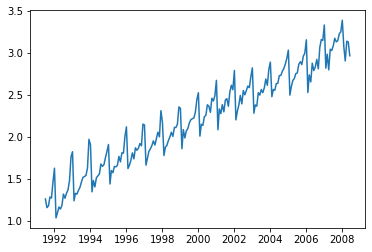

In [220]:
plt.plot(np.log(df['value']))
plt.show()

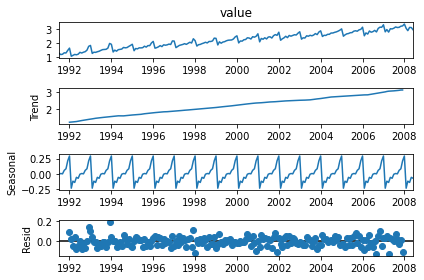

In [221]:
additive_log_model = seasonal_decompose(np.log(df['value']), model='additive')
additive_log_model.plot()
plt.show()

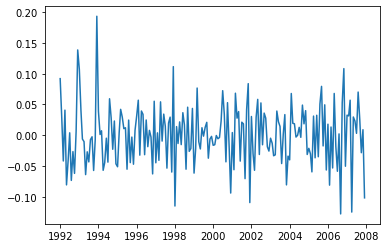

In [222]:
plt.plot(additive_log_model.resid)
plt.show()

In [233]:
df['value'] = additive_log_model.resid.copy()

# SARIMA

## Giải thích mô hình SARIMA

## Xây dựng mô hình SARIMA

### ACF, PACF theo từng order

In [243]:
df = df.rename(columns={'value': 'value_diff0'})

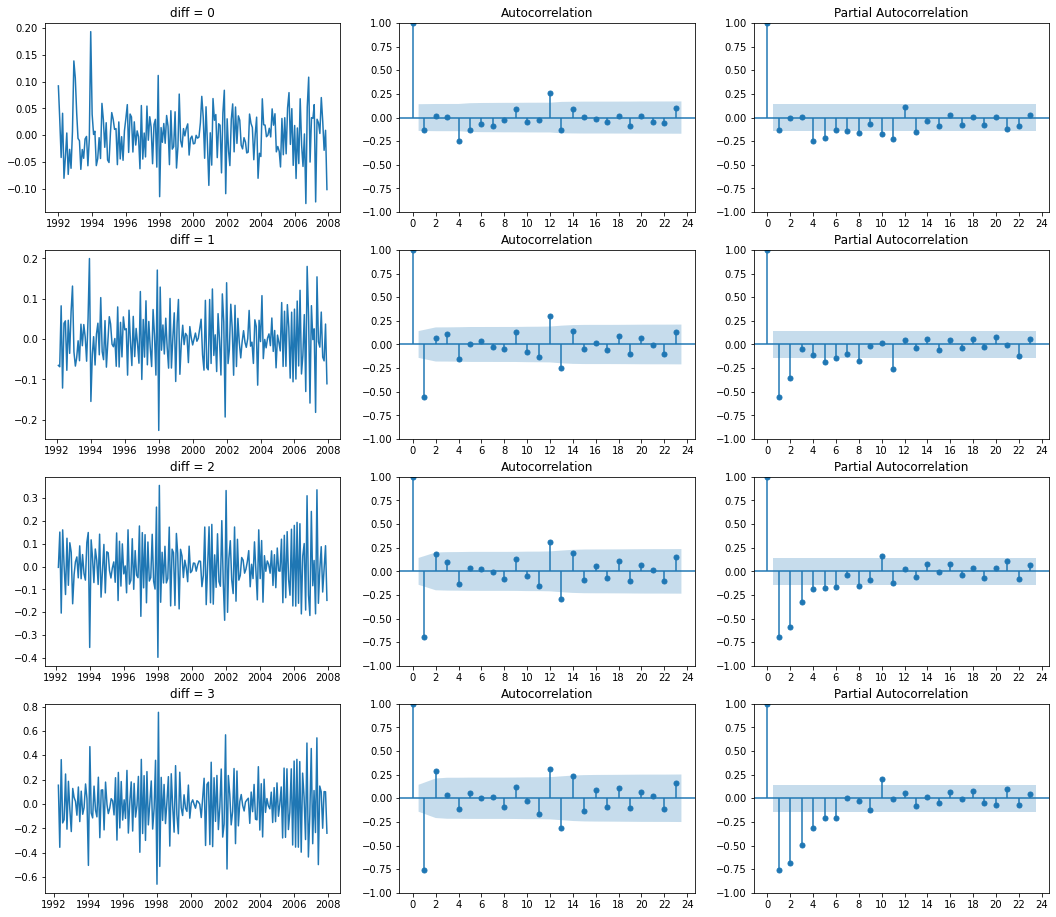

In [245]:
difference_order = 3

# 3 columns: plotting the difference, the ACF, and the PACF
fig, axes = plt.subplots(difference_order+1, 3, figsize=(18, 16))

for i in range(difference_order):
    df[f'value_diff{i+1}'] = df[f'value_diff{i}'].diff()

for i in range(difference_order + 1):
    diff = df[f'value_diff{i}']
    ax = axes[i]
    
    # Plot the difference
    ax[0].plot(diff)
    ax[0].set_title(f'diff = {i}')
    
    # Plot ACF
    plot_acf(diff.dropna(), ax=ax[1])
    ax[1].xaxis.set_major_locator(MultipleLocator(2))
    
    # Plot PACF
    plot_pacf(diff.dropna(), ax=ax[2], method='ywm')
    ax[2].xaxis.set_major_locator(MultipleLocator(2))

### Xây dựng mô hình

In [247]:
train_end = dt.datetime(2007, 1, 1)
test_end = dt.datetime(2008, 1, 1)

train = df[:train_end]['value_diff0'].copy()
test = df[train_end + dt.timedelta(days=1):test_end]['value_diff0'].copy()

In [262]:
# Chọn AR order bằng 11 dựa trên PACF
order = (6, 2, 0)

# Chọn seasonal MA order bằng 1 dựa trên ACF
seasonal_order = (0, 0, 1, 12)

In [263]:
model_sarima = SARIMAX(train, order=order, seasonal_order=seasonal_order)

/home/mdnam/.local/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/mdnam/.local/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [264]:
%%time
model_sarima_fitted = model_sarima.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.26574D+00    |proj g|=  1.34307D+00

At iterate    5    f= -1.26815D+00    |proj g|=  3.58106D-01

At iterate   10    f= -1.26949D+00    |proj g|=  2.39597D-02


 This problem is unconstrained.



At iterate   15    f= -1.26952D+00    |proj g|=  8.88594D-02

At iterate   20    f= -1.26955D+00    |proj g|=  2.13817D-03

At iterate   25    f= -1.26955D+00    |proj g|=  1.22259D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     28     65      2     0     0   1.646D-03  -1.270D+00
  F =  -1.2695543056924232     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
CPU times: user 1.1 s, sys: 10.2 ms, total: 1.11 s
Wall time: 961 ms



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


### Đánh giá và dự báo

In [265]:
print(model_sarima_fitted.summary())

                                      SARIMAX Results                                       
Dep. Variable:                          value_diff0   No. Observations:                  187
Model:             SARIMAX(6, 2, 0)x(0, 0, [1], 12)   Log Likelihood                 237.407
Date:                              Sun, 08 May 2022   AIC                           -458.813
Time:                                      15:03:04   BIC                           -433.050
Sample:                                  07-01-1991   HQIC                          -448.372
                                       - 01-01-2007                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4890      0.071    -20.839      0.000      -1.629      -1.349
ar.L2         -1.42

In [266]:
model_sarima_fitted.forecast(len(test))

2007-02-01   -0.016200
2007-03-01    0.011706
2007-04-01    0.039994
2007-05-01    0.087447
2007-06-01    0.022298
2007-07-01    0.034746
2007-08-01    0.050029
2007-09-01    0.005922
2007-10-01    0.099543
2007-11-01    0.112053
2007-12-01    0.064400
2008-01-01    0.094913
Freq: MS, Name: predicted_mean, dtype: float64

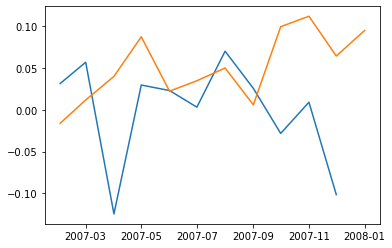

In [268]:
plt.plot(test)
plt.plot(model_sarima_fitted.forecast(len(test)))
plt.show()

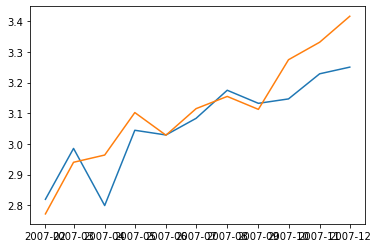

In [285]:
plt.plot((additive_log_model.trend + additive_log_model.seasonal).loc[test.index] + test)
plt.plot((additive_log_model.trend + additive_log_model.seasonal).loc[test.index] + model_sarima_fitted.forecast(len(test)))